In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
pedidos = pd.read_csv('./Dados/Amostra_Pedidos.csv', parse_dates=['Início Entrega', 'Término Entrega'])

In [ ]:
pedidos['Horário Entrega'] = pedidos['Início Entrega'].dt.floor('30min').dt.strftime('%H:%M')

In [ ]:
pedidos_minimos = pedidos.groupby('Estabelecimento').filter(lambda x: len(x) > 30)
amostra_aleatoria = pd.Series(pedidos_minimos['Estabelecimento'].unique()).sample(3, random_state=123)
amostra = pedidos_minimos[pedidos_minimos['Estabelecimento'].isin(amostra_aleatoria)]

In [ ]:
fig, axs = plt.subplots(ncols=3, figsize=(16, 4))
grupos = amostra.groupby('Estabelecimento')

for (chv, grp), ax in zip(grupos, axs.ravel()):
    grp.groupby('Horário Entrega').agg(pedidos=('Ident. Pedido', 'count')).plot(kind='bar', legend='', xlabel='', ax=ax)
    ax.set_title(grp['Tipo Estab.'].unique()[0])

0.9359404409481582
0.9404772686416355
4.223820603730789
1.3097744842303518
0.9404772736197332
[5 3 2 7]


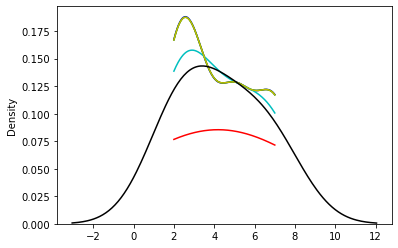

In [122]:
import numpy as np
from scipy.stats import norm, scoreatpercentile
from scipy.optimize import minimize
from matplotlib import pyplot as plt
import seaborn as sns

x = np.array([5, 3, 2, 7]).reshape(-1, 1)
b = 0.2

def kernel(x, b):
    s = np.linspace(np.min(x), np.max(x), 10)
    k_x = [[norm.pdf((j - i) / b, 0, 1) for j in x] for i in s]
    return s, np.mean(np.sum(k_x, axis=1) / b)

def scott(x):
    return 3.49 * np.std(x) * len(x) ** (-0.333)
    
def silverman(x):
    iqr = (scoreatpercentile(x, 75) - scoreatpercentile(x, 25)) / 1.349
    return 0.9 * np.min([np.std(x), iqr if iqr > 0 else np.std(x)]) * len(x) ** (-0.2)

def likelihood(b, x):
    n = len(x)
    s = np.linspace(np.min(x), np.max(x), n)
    k_x = [[np.zeros(1) if i == j else norm.pdf((j - i) / b, 0, 1) for j in x] for i in s]

    return -(n-1)**-n * b**-n * np.prod(np.sum(k_x, axis=1) / b)
    
def loglike(b, x):
    n = len(x)
    s = np.linspace(np.min(x), np.max(x), n)
    k_x = [[np.zeros(1) if i == j else norm.pdf((j - i) / b, 0, 1) for j in x] for i in s]
    k_x_norm = np.sum(k_x, axis=1) / b

    return -(1/n) * np.sum(np.log(k_x_norm[k_x_norm > 0]) - np.log((n-1)*b))
    

def loglike2(b, x):
    n = len(x)
    s = np.linspace(np.min(x), np.max(x), n)
    k_x = [[np.zeros(1) if i == j else norm.pdf((j - i) / b, 0, 1) for j in x] for i in s]

    return -np.log((n-1)**-n * b**-n * np.prod(np.sum(k_x, axis=1) / b))


nm = np.array([norm.pdf((x -np.mean(x)) / b, 0, 1)])
shp = (1/b) * sum(nm / len(x))

normal = lambda u: 1 / np.sqrt(2 * np.pi) * np.exp(-1 / 2 * u * u)

c = minimize(likelihood, 1, x)['x'][0]
d = minimize(loglike, 1, x)['x'][0]
e = scott(x)
f = silverman(x)
g = minimize(loglike2, 1, x)['x'][0]
print(c)
print(d)
print(e)
print(f)
print(g)

s, shp1 = kde(x, c)
s, shp2 = kde(x, d)
s, shp3 = kde(x, e)
s, shp4 = kde(x, f)
s, shp5 = kde(x, g)

fig, ax = plt.subplots()
ax.plot(s, shp1, color='b')
ax.plot(s, shp2, color='g')
ax.plot(s, shp3, color='r')
ax.plot(s, shp4, color='c')
ax.plot(s, shp5, color='y')
#ax.hist(x, density=True)
print(np.concatenate(x))
plote = sns.kdeplot(np.concatenate(x), color='k', bw_method='scott',  ax=ax)
plt.show()